## 第四章
* 前面的线性神经网络可以说是所有网络的基础，但它本身的表达能力非常有限，真正的深度网络一定需要具备拟合非线性关系的能力，因此本章引入了最简单的深度网络：**多层感知机(MLP)** 
* 多层感知机作为深度网络的一种，会遇到很多深度模型都会遇到的问题，例如过拟合和欠拟合、模型选择、正则化技术、计算性能效率等，因此以多层感知机为例，这一章也会关心这些基本问题

### 4.1 多层感知机的简单介绍

* 这里d2l用了很大的篇幅来介绍MLP，这里对文字部分做一个简短且深刻的总结：    
    首先线性模型的表达能力非常有限，单个特征只能正向或者负向线性地影响观测数据的变化，但这在现实生活中是很难见到的，一般的模式识别任务都会有非线性的情况，需要更为复杂的网络来表示，比如我们之前的softmax用多个像素的像素值强度来映射到分类类别，这本身就具有一定的局限性  
    所以解决办法是什么呢？很简单，我们只需要在网络中加上一些隐藏层，但光加隐藏层还不行，我们用下面的公式来表示，$\mathbf{X} \in\mathbb{R}^{n \times d}$表示n个样本的小批量，每个样本具有d个输入特征；单隐藏层的多层感知机的中间层可以表示为
    $\mathbf{H} \in \mathbb{R}^{n\times h}$,其中h表示隐藏单元的个数，
    $\mathbf{H}$ 也被称为隐藏层变量或隐藏变量，我们再假定这个单隐藏层的多层感知机的输出为
    $\mathbf{O} \in \mathbb{R}^{n\times q}$,这样我们可以将多层感知机的处理表示为：
    $$
        \mathbf{H} = \mathbf{X}\mathbf{W}^{(1)} + \mathbf{b}^{(1)} \\
        \mathbf{O} = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}
    $$
    上述的模型中没有任何进步的地方，原因在于隐藏单元由输入的仿射函数给出，而输出只是隐藏单元的仿射函数，仿射函数的仿射函数还是仿射函数，换句话说，通过上述这样设计的多层感知机能做到的线性映射，没有隐藏层的常规单层输入-输出模型也完全可以做到！  
    所以既然采用了这样的多层结构，就一定要对内部做一定的改进，多层感知的关键要素在于：**在仿射变换之后对每个隐藏单元应用非线性的激活函数(activation function)$\sigma$**，自然由激活函数处理后的输出被称为**活性值(activations)**。引入了激活函数之后，多层感知机变成下面的样子：
    $$
        \mathbf{H} = \sigma{(\mathbf{X}\mathbf{W}^{(1)} + \mathbf{b}^{(1)})} \\
        \mathbf{O} = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}
    $$

    多层感知机的设计有其遵循的数学原理————通用近似定理，多层感知机是通用近似器，即便网络只有一个隐藏层，在给定足够的神经元和正确的权重后，这个简单的多层感知机也可以对任意函数建模。虽然一个单隐藏层的网络理论上可以学习任何函数，但在实际情况下仍然不能指望单隐藏层的网络去解决所有问题

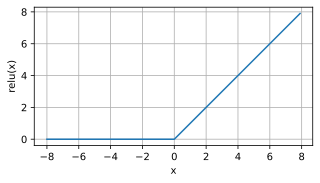

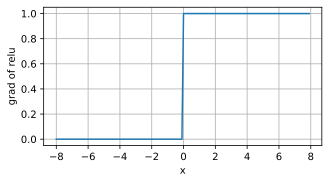

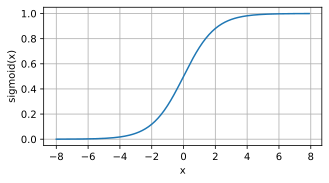

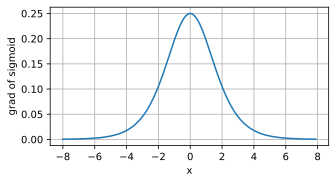

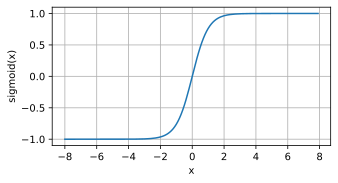

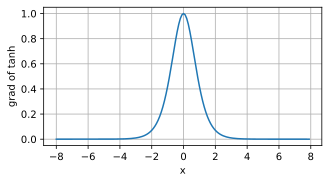

In [10]:
# 既然多层感知机相较于最基础的线性网络的最大区别在于激活函数的引入，那么本节主要介绍几个常用的激活函数的效果
import torch
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display

# 使用之前定义的plot函数
def use_display():
    backend_inline.set_matplotlib_formats("svg")
# backend_inline是IPython库的一个模块，主要作用是控制matplotlib图表的显示方式，设置的"svg"是一种矢量图格式，svg是一种基于XML的矢量图形格式，与"png"等位图格式不同，矢量图形格式可以做到无损缩放，但渲染复杂图形时消耗资源更多

def set_figsize(figsize = [3.5,2.5]):
    use_display()
    plt.rcParams["figure.figsize"] = figsize


def set_axes(axes,xlabel,ylabel,xscale,yscale,xlim,ylim,legend=None):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.grid()
    if legend:
        axes.legend(legend)

# 上述的所有格式设置都是为了下面的plot函数服务，plot函数考虑了这样几种情况：只有y轴方向的数据，这意味着x轴坐标可能不重要，默认赋值为[0,n-1];在相同的x轴取值下，同时画出多条函数曲线

def plot(X, Y=None, xlabel=None, ylabel=None, xscale='linear', yscale='linear', xlim=None, ylim=None, fmts=('-','m--','g-.','r:'), figsize=(3.5,2.5), axes=None, legend=None):
    # fmts中指定了四种绘图格式，默认的plot曲线颜色为蓝色，'-'也是默认格式，表示实线，‘--’表示虚线，‘-.’表示点划线，':'表示点线
    if legend is None:
        legend = []
    
    set_figsize(figsize)
    axes = axes if axes else plt.gca() # 未指定特定的绘图axes就选择当前的axes

    def has_oneaxis(x):
        if hasattr(x,"ndim") and x.ndim == 1 or isinstance(x,list) and not hasattr(x[0],"__len__"):
            return True
    # 这里的函数判断了两类情况，首先如果不是普通的list，那指定ndim==1确定了只会是一维的计算单元；如果是list类型，则x[0]没有'__len__'使得也不会出现二维以上的多维情况

    if has_oneaxis(X):
        X = [X] # 不管在调用plot函数时有没有指定y，这样的操作都会在原来的x基础上再套一个[],使得原来一维的计算单元变成了[1,n]这样的结构，这样的主要原因是为了配合后面的多组同时绘制

    if Y is None:
        X, Y = [[]] * len(X), X # 主要是为了处理未指定Y的情况,首先会执行将X的值赋给Y，再将X设置为对应长度的[]，这里设置对应长度主要是为了配合zip的解包
    elif has_oneaxis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()

    for x,y,fmt in zip(X,Y,fmts):
        if len(x):
            plt.plot(x,y,fmt)
        else:
            plt.plot(y,fmt)
    
    set_axes(axes,xlabel,ylabel,xscale,yscale,xlim,ylim,legend)

# 首先是最常用的RELU激活函数
x = torch.arange(-8.0,8.0,0.1, requires_grad=True) # 前闭后开
y = torch.relu(x)
plot(x.detach(),y.detach(),"x","relu(x)",figsize=(5,2.5))
plt.show()
# 输入为负时，RELU会将输入输出为0，当输入为正时，RELU保留原来的输入值
y.backward(torch.ones_like(x),retain_graph=True)
plot(x.detach(),x.grad,"x","grad of relu",figsize = (5,2.5))
plt.show()
# d2l这里介绍了RELU的变种，RELU的变种有非常多，完全可以不用特别留心记忆，遇到一些特别的再留个印象即可

# 接下来是也比较常见的sigmoid激活函数
y = torch.sigmoid(x)
plot(x.detach(),y.detach(),"x","sigmoid(x)",figsize=(5,2.5))
plt.show()
x.grad.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plot(x.detach(),x.grad,"x","grad of sigmoid",figsize=(5,2.5))
plt.show()

# 最后是和sigmoid类似的tanh激活函数，这个激活函数同样也是二分类的，区别在于tanh将两头放在了-1和1，而不是sigmoid的0和1
y = torch.tanh(x)
plot(x.detach(),y.detach(),"x","sigmoid(x)",figsize=(5,2.5))
plt.show()
x.grad.zero_()
y.backward(torch.ones_like(x))
plot(x.detach(),x.grad,"x","grad of tanh",figsize=(5,2.5))
plt.show()

- 这里添加一个markdown的说明，主要为了说明三种常见的激活函数的数学表达形式

- RELU激活函数的数学形式：
$$
    \mathbf{ReLU}(x) = \mathbf{max}(x,0)
$$

- sigmoid激活函数的数学形式：
$$
    \mathbf{sigmoid}(x) = \frac{1}{1+e^{-x}}
$$

- tanh激活函数的数学形式：
$$
    \mathbf{tanh}(x) = \frac{1-\mathbf{exp}(-2x)}{1+\mathbf{exp}(-2x)}
$$

### 4.2 多层感知机的从零开始实现

In [4]:
# 从零实现多层感知机需要用到第三章的训练函数
# 接下来正式从零开始，主要包括初始化模型参数、定义softmax、定义模型、定义损失函数、描述分类精度、训练函数、绘图函数、预测函数等等
import torch
import torchvision
from IPython import display
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from torch.utils import data
from torchvision import transforms

# 当输出的概率中最大的那个实际上就是网络判断的预测类别，因此既然有真实类别和预测类别，自然就会有分类是否正确的问题，所以在这个示例中也定义一个计算分类精度的
def accuracy(y_hat, y):
    if y_hat.shape[1] > 1 and len(y_hat.shape) > 1:
        y_hat = y_hat.argmax(axis=1) # torch.tensor的方法
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

# 定义一个实用类，用于记录一些变量并完成累加操作
class Accumulator:
    def __init__(self,n):
        self.data = [0.0] * n
    
    def add(self,*args):
        self.data = [a + float(b) for a,b in zip(self.data,args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self,idx):
        return self.data[idx]
    
# 在Accumulator类的基础上定义记录预测精度的函数
def evaluate_accuracy(net, data_iter):
    '''Accumulator实例中第一个记录的是预测正确的样本数 第二个记录的是总的样本数'''
    if isinstance(net,torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return (metric[0] / metric[1])

# 接下来定义训练的专用函数
def train_epoch_ch3(net,train_iter,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train()
    metric = Accumulator(3) # Accumulator实例中有三个变量，第一个记录单次epoch中所有的loss和，第二个记录预测正确的样本数，第三个记录总的样本数
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward() # 这里传入sum()的主要原因是我们自定义的sgd是除了一个batch_size的，并且sgd函数中有梯度清零的操作
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    return metric[0]/metric[2], metric[1]/metric[2]

# 这里有一个在d2l包中定义的绘制专用类，可以直接用现成的，也可以重新在这里定义
def set_axes(axes,xlabel,ylabel,xlim,ylim,xscale,yscale,legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.grid()
    if legend:
        axes.legend(legend)

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None,
                 xlim=None, ylim=None, xscale='linear', yscale='linear',
                 fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,
                 figsize=(3.5,2.5)):
        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows,ncols,figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda:set_axes(
            self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend
        )
        self.X, self.Y, self.fmts = None, None, fmts
    
    def add(self,x,y):
        if not hasattr(y,"__len__"):
            y = [y]
        n = len(y)
        if  not hasattr(x,"__len__"):
            x = [x] * n
        # self.X和self.Y这两个类其实是为了画出loss和在训练集和测试集上随着训练epoch的变化情况，因此长度就是3
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x,y,fmt in zip(self.X,self.Y,self.fmts):
            self.axes[0].plot(x,y,fmt)
        self.config_axes() # 灵活运用lambda函数省去重复使用复杂函数
        display.display(self.fig)
        display.clear_output(wait=True) # display这个模块的引入主要是为了动态画出变化的过程 直接plot + show 无法实现这种动态变化的效果

# 上面的绘画类实际上画出的是多个epoch之间的变化情况，因此在实现单次训练迭代的基础上定义总的训练函数

def train_ch3(net, train_iter, test_iter, loss ,num_epochs, updater):
    animator = Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,1.0],legend=["train loss", 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net,train_iter,loss,updater)
        test_acc = evaluate_accuracy(net,test_iter)
        animator.add(epoch+1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <=1 and train_acc > 0.7, train_acc
    assert test_acc <=1 and test_acc > 0.7, test_acc # 判断一下特殊情况

# 训练完成后，我们可以运用训练结束的网络进行预测，这里用到了前面的显示图片和类别的函数

def show_labels(labels):
    name_labels = ['t-shirt','trousers','pullover','dress','coat','sandel','shirt','sneaker','bag','ankle boot']
    return [name_labels[int(i)] for i in labels] # 要写int 不然不能正确索引

def show_images(images,num_rows,num_cols,scale=1.5,labels=None):
    figure_size = [num_cols*scale,num_rows*scale]
    _,axes = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figure_size)
    axes = axes.flatten()
    for i,(axe,image) in enumerate(zip(axes,images)):
        if torch.is_tensor(image):
            axe.imshow(image.numpy())
        else:
            axe.imshow(image)
        axe.axes.get_xaxis().set_visible(False)
        axe.axes.get_yaxis().set_visible(False)
        if labels:
            axe.set_title(labels[i])

def predict_ch3(net, test_iter, n=6):
    for X,y in test_iter:
        break
    trues = show_labels(y)
    preds = show_labels(net(X).argmax(axis=1))
    titles = [true+"\n"+pred for true,pred in zip(trues,preds)]
    show_images(X.squeeze(),1,n,labels=titles[0:n])


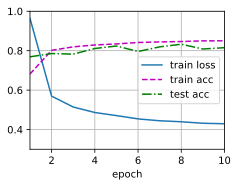

In [6]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import torch.nn as nn

batch_size = 256
# 使用在第三章的数据集定义函数
def load_data_fashion_mnist(batch_size,resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="./data",download=False,transform=trans,train=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="./data",download=False,transform=trans,train=False)
    return data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True),data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True)

train_iter, test_iter = load_data_fashion_mnist(batch_size)

# 这里选择单隐藏层的多层感知机，隐藏层的节点个数为256
num_inputs, num_outputs, num_hidden = 784, 10, 256
W1 = nn.Parameter(torch.randn((num_inputs,num_hidden),requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hidden,requires_grad=True))
W2 = nn.Parameter(torch.randn((num_hidden,num_outputs),requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs,requires_grad=True))

params = [W1,b1,W2,b2]

def relu(x):
    a = torch.zeros_like(x)
    return torch.max(a,x)

def net(X):
    X = X.reshape((-1,num_inputs))
    y1 = X @ W1 + b1
    return (y1 @ W2 + b2)

loss = nn.CrossEntropyLoss(reduction="none")

num_epochs = 10
lr = 0.1
updater = torch.optim.SGD(params, lr=lr)

train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)


#### 4.3 多层感知机的简洁实现

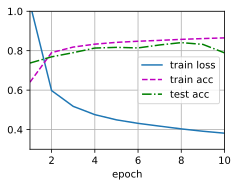

In [7]:
# 上面的从零实现其实不是真正意义上的from scratch，省略的原因在于很多从零实现的代码比如优化器、损失函数等都在第三章实现过，因此从零实现的也就只有网络部分
# 简洁实现的主要区别就是网络结构由torch.nn实现
import torch.nn as nn
import torch

net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,256),
                    nn.ReLU(),
                    nn.Linear(256,10))

def init_weights(m):
    '''其实这个初始化参数不是很有必要，原因在于pytorch其实会选择比较适当的例如kaiming初始化等来处理网络参数'''
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)

net.apply(init_weights) # 网络参数的初始化方式
batch_size = 256
lr = 0.1
num_epochs = 10

loss = nn.CrossEntropyLoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(),lr = lr)

train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

### 4.4 模型选择、欠拟合和过拟合